In [1]:
# @title: imports, and graphics setup
import sys
sys.path.append('..')
from multiprocessing import Pool, TimeoutError
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline
import matplotlib.colors as mcol
import matplotlib.cm as cm
import numpy as np
import mpmath as mp
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy import integrate as integrate
from Modules.potential_operations import histogram_potential_fitter, normalized_pdf_from_potential, generate_theoretical_pdf_for_fit
from Modules.custom_simulations import simulate_particles_in_external_force_Not_HOOMD
import warnings
from scipy.optimize import fsolve
from tqdm.auto import tqdm, trange
from Modules.pdfs import *
from joblib import Parallel, delayed
import re

%matplotlib inline
matplotlib.style.use('default')
matplotlib_inline.backend_inline.set_matplotlib_formats('png')

In [2]:
from Modules.potentials import harmonic_potential
from Modules.forces import harmonic_force

In [3]:
def run_simulation(n_particles, steps, x_start_position, force ,force_args, delta_fraction,dt, kT, gamma):
    start_position=x_start_position
    args = [force, n_particles, steps, delta_fraction]
    trajectories = simulate_particles_in_external_force_Not_HOOMD(*args, dt=dt, kT=kT, force_args=force_args, start_position=start_position, gamma=gamma, type=np.float32)
    x_positions = np.array(trajectories)
    return x_positions

#### units converter

In [4]:
real_k_conv_factor = 1e-6

dt = 0.1
def convert_arbitrary_time_to_seconds(sim_gamma, real_k_conv_factor=1e-6, real_R=0.5*1e-6):
    water_viscosity = 0.00089
    real_gamma = 6 * np.pi * water_viscosity * real_R
    real_time_scale = real_gamma/real_k_conv_factor
    sim_time_scale = sim_gamma/1
    real_time =  real_time_scale/sim_time_scale #units: sec/sim_time
    return real_time #units: sec/sim_time

print('Real dt =',dt*convert_arbitrary_time_to_seconds(500, real_k_conv_factor=1*1e-6, real_R=0.5*1e-6), 'seconds')


print('Real k =',5*real_k_conv_factor, 'pN/um')

Real dt = 1.6776104770169494e-06 seconds
Real k = 4.9999999999999996e-06 pN/um


## Simulation

In [5]:
### Simulation Parameters ###

dt = 0.1
gamma = 500
kT = 1
steps = 15000
n_particles = 20000
batch_size = 10000
batches = int(n_particles/batch_size)
D=kT/gamma

### Harmonic Potential Parameters ###
#k_harm = 5
k_harm = 10
force_args = [k_harm]
typical_relaxation_time = gamma/k_harm

### resetting parameters ### 
delta_fractions = (k_harm/5)*np.linspace(0, 0.01, 6)
colors = cm.rainbow(np.linspace(0, 1, len(delta_fractions)))
resetting_rates = delta_fractions/dt
real_time_resetting_rates = resetting_rates / convert_arbitrary_time_to_seconds(gamma)
print('Resetting rates:', real_time_resetting_rates*1e-3, 'kHz')

sherf_nums = gamma*resetting_rates/k_harm
print('Sherf numbers:', sherf_nums)

resetting_rates_str = [f'{rate:.3f}'[1:] for rate in resetting_rates]
resetting_rates_str = ','.join(resetting_rates_str)
folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str}'
if k_harm != 5:
    folder += f'_K-{k_harm}'
print('Folder -', folder)

trajectories_per_rate = None

Resetting rates: [ 0.          2.38434372  4.76868743  7.15303115  9.53737487 11.92171858] kHz
Sherf numbers: [ 0.  2.  4.  6.  8. 10.]
Folder - HarmonicPotentialTrajectories/R-.000,.040,.080,.120,.160,.200_K-10


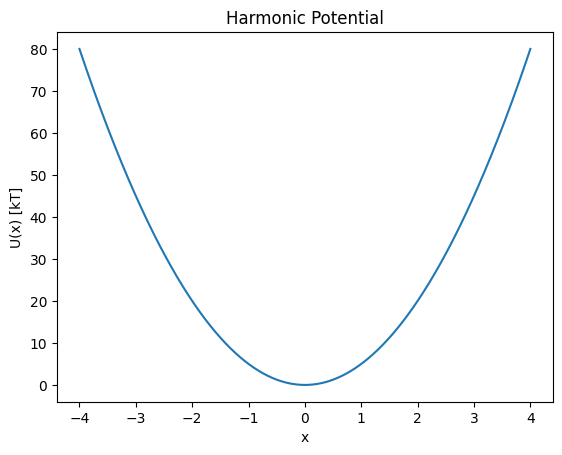

In [6]:
### plot potential ###
potential_x = np.linspace(-4, 4, 1000)
potential_y = harmonic_potential(potential_x, k_harm)/kT
plt.plot(potential_x, potential_y)
plt.xlabel('x')
plt.ylabel('U(x) [kT]')
plt.title('Harmonic Potential')
plt.show()

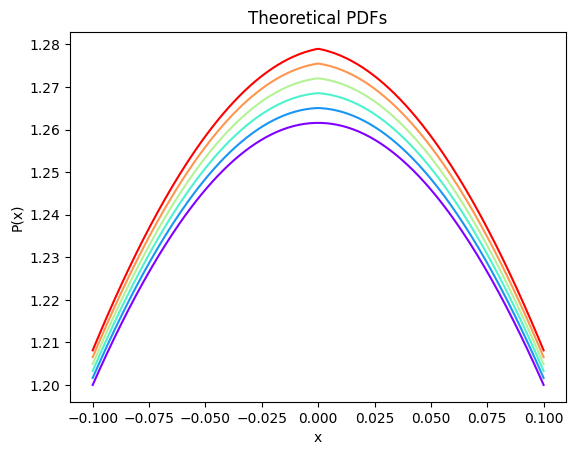

In [7]:
### Plot theroetical pdf ###
x = np.linspace(-0.1, 0.1, 250)
for r, c in zip(resetting_rates, colors):
    if r == 0:
        pdf = pdf_harmonic_boltzmann(k_harm, kT)
    else:
        pdf = lambda x: pdf_resetting_in_harmonic_potential(x, k_harm, r*dt, shift=0, dt=dt, kT=kT)
    plt.plot(x, pdf(x), label=f'{r:.3f}', color=c)
plt.xlabel('x')
plt.ylabel('P(x)')
plt.title('Theoretical PDFs')
plt.show()

In [8]:
#raise KeyboardInterrupt
### Run simulations ###
print([int(a) for a in np.arange(0 , n_particles, batch_size)])
os.makedirs(folder, exist_ok=True)
filenames = os.listdir(folder)
existing_batches = 0
for file in filenames:
    if re.search("^batch.*npy", file):
        nums = re.findall((r'\d+'), file)
        n = ''.join(nums)
        if int(n) > existing_batches:
            existing_batches = int(n)
print("Existing Batches: ", existing_batches)
if __name__ == "__main__":
    for _ in np.arange(0 , n_particles, batch_size):
        simulation_parameters = [(batch_size, steps, 0, harmonic_force, force_args, delta_fraction, dt, kT, gamma) for delta_fraction in delta_fractions]
        trajectories_per_rate = Parallel(n_jobs=-2, verbose = 1, backend='loky')(delayed(run_simulation)(*args) for args in simulation_parameters)
        np.save(folder+f'/batch_{int(_/batch_size)+1+existing_batches}.npy', trajectories_per_rate)
        print(f'Finished {_+batch_size} particles')
    print('Finished all particles')

[0, 10000]
Existing Batches:  0


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   6 out of   6 | elapsed:    8.4s finished


Finished 10000 particles


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   6 out of   6 | elapsed:    8.5s finished


Finished 20000 particles
Finished all particles


In [9]:
if trajectories_per_rate is None:
    filenames = os.listdir(folder)
    trajectories = np.load(folder+'/'+filenames[0])
    trajectories_per_rate = np.array(trajectories)
    del trajectories

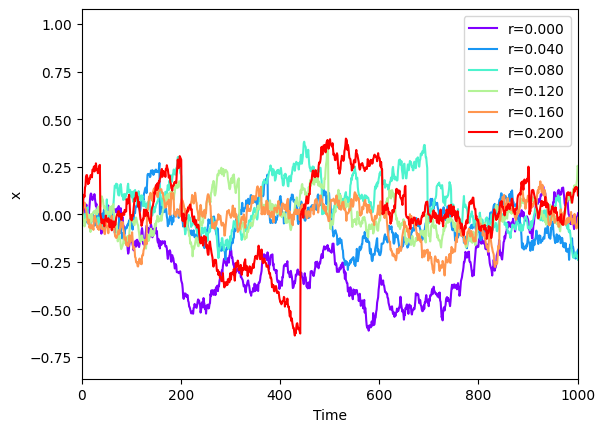

In [10]:
### plot trajectories ###
for i, [rate, trajs] in enumerate(zip(resetting_rates, trajectories_per_rate)):
    plt.plot(np.arange(steps), trajs[:, 0], label=f'r={rate:.3f}', color=colors[i])
plt.xlabel('Time')
plt.ylabel('x')
plt.legend()
plt.xlim(0, 1000)
plt.show()

In [11]:
import array


def _calculate_single_mean_var(x_pos):
    mean = np.mean(x_pos, axis=1)
    var = np.var(x_pos, axis=1)
    return mean, var

def calculate_mean_var_trajectory_per_rate(trajs):
    # Using parallel processing for each trajectory
    #means_vars_per_pos = Parallel(n_jobs=-1, prefer='threads')(
    #    delayed(_calculate_single_mean_var)(x_pos) for x_pos in trajs
    #)
    ### not parallel version
    means_vars_per_pos = []
    for x_pos in trajs:
        means_vars_per_pos.append(_calculate_single_mean_var(x_pos))
    return np.array(means_vars_per_pos)

def _calculate_single_histogram(x_pos, bins, timesteps, n_samples, n_target_distribution_samples):
    histograms_per_timestep = []
    target_distribution_points = x_pos[-n_target_distribution_samples:]
    target_distribution, _ = np.histogram(target_distribution_points, bins=bins, density=True)
    for timestep in timesteps:
        if timestep != 0:
            histogram, bin_edges = np.histogram(x_pos[timestep:timestep+n_samples], bins=bins, density=True)
        else:
            histogram, bin_edges = np.histogram(x_pos[timestep:timestep+1], bins=bins, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        histograms_per_timestep.append([histogram, bin_centers])
    histograms_per_timestep.append([target_distribution, bin_centers])
    return histograms_per_timestep

def generate_histograms_per_rate(trajs, bins, timesteps, n_samples, n_target_distribution_samples):
    histograms_per_rate = []
    histograms_per_rate = Parallel(n_jobs=-1, prefer='threads')(delayed(_calculate_single_histogram)(x_pos, bins, timesteps, n_samples, n_target_distribution_samples) for x_pos in trajs)
    '''
    for x_pos in trajs:
        histograms_per_rate.append(_calculate_single_histogram(x_pos, bins, timesteps, n_samples, n_target_distribution_samples))
    histograms_per_rate = np.array(histograms_per_rate)
    '''
    return histograms_per_rate

def calculate_average_measure_per_batches(folder, measure, batches=-1, args=[]):
    if batches == 0:
        return None
    c = 0
    for filename in os.listdir(folder):
        if filename.endswith('.npy') and filename[0:5] == 'batch':
            trajectories_per_r = np.array(np.load(folder+'/'+filename)) 
            if c == 0:
                if measure != generate_histograms_per_rate:
                    value = measure(trajectories_per_r, *args)
                else:
                    value = np.array(measure(trajectories_per_r, *args))
            else:
                if measure != generate_histograms_per_rate:
                    value += measure(trajectories_per_r, *args)
                else:
                    value += np.array(measure(trajectories_per_r, *args))
            c+=1
            if batches != -1 and batches == c:
                break
            del trajectories_per_r
            if batches == -1:
                print(f'finished batch {c}')
            else:
                print(f'finished batch {c} of {batches}')
            if batches != -1 and batches == c:
                break
    if measure != generate_histograms_per_rate:
        final_value = value/c
    else:
        final_value = np.array(value)/c
    return final_value

In [12]:
means_vars = calculate_average_measure_per_batches(folder, calculate_mean_var_trajectory_per_rate, batches=4)
means = means_vars[:, 0]
vars = means_vars[:, 1]
del means_vars

finished batch 1 of 4
finished batch 2 of 4


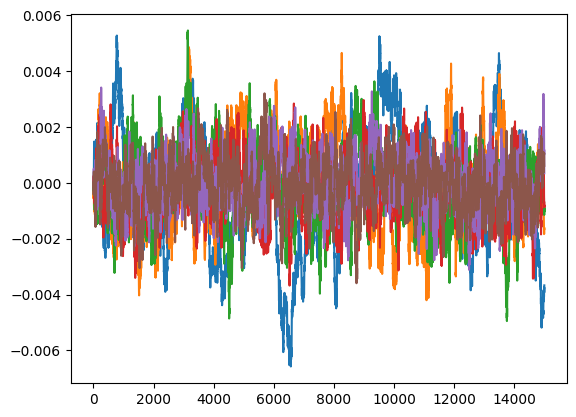

In [13]:
### plot mean per r ### 
for r,mean_traj in zip(resetting_rates,means):
    plt.plot(mean_traj)
plt.show()

In [14]:
np.save(folder+'/mean_trajectories.npy', means)

In [15]:
means = np.load(folder+'/mean_trajectories.npy')

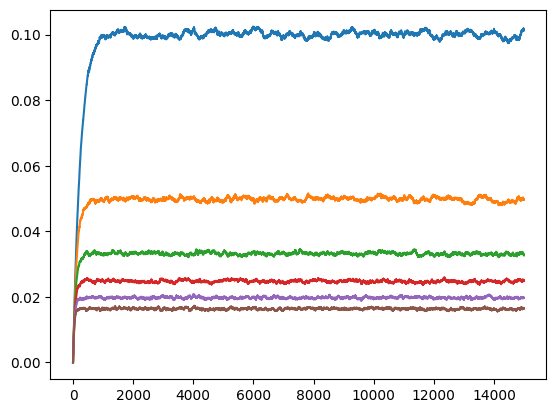

In [16]:
### plot vars per start ### 
for r,vars_traj in zip(resetting_rates,vars):
    plt.plot(vars_traj)
plt.show()

In [17]:
np.save(folder+'/var_trajectories.npy', vars)

In [18]:
vars = np.load(folder+'/var_trajectories.npy')
print(vars.shape)

(6, 15000)


In [19]:
samples = 5
target_distribution_samples = 500
steady_state = 12000
timesteps = np.arange(0, steady_state, 5)
histograms_per_start_pos = []
bin_edges = np.histogram_bin_edges(trajectories_per_rate[-1][-samples:], bins=201)
bins = bin_edges*2

In [20]:
del trajectories_per_rate

In [21]:
batches_to_process = -1
args = [bins, timesteps, samples, target_distribution_samples]
histograms_per_rate = calculate_average_measure_per_batches(folder, generate_histograms_per_rate, args=args, batches=batches_to_process)


finished batch 1
finished batch 2


In [22]:
np.save(folder+'/histograms_per_rate.npy', histograms_per_rate)

In [23]:
histograms_per_rate = np.load(folder+'/histograms_per_rate.npy')

0.999998399600168
0.9999999838163949
0.9999999678643829
0.9999999511171735
0.9999999349292946
0.999999917730227


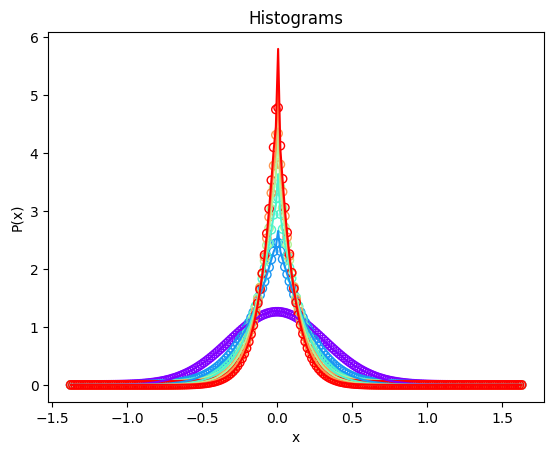

In [24]:
### plot histograms at ss ###
for i, (histograms_per_time, r, c) in enumerate(zip(histograms_per_rate, resetting_rates, colors)):
    hist, bin_centers = histograms_per_time[-1]
    print(np.trapezoid(hist, bin_centers))
    plt.plot(bin_centers, hist, label=f'{resetting_rates[i]:.3f}', color=c)
    if r == 0:
        pdf = pdf_harmonic_boltzmann(k_harm, kT)
    else:
        pdf = lambda x: pdf_resetting_in_harmonic_potential(x, k_harm, r*dt, shift=0, dt=dt, kT=kT, gamma=gamma)
    nf = np.trapezoid(pdf(bin_centers), bin_centers)
    plt.scatter(bin_centers, pdf(bin_centers), label=f'{r:.3f}', color=c, marker='o', facecolors='none')
plt.xlabel('x')
plt.ylabel('P(x)')
plt.title('Histograms')
plt.show()

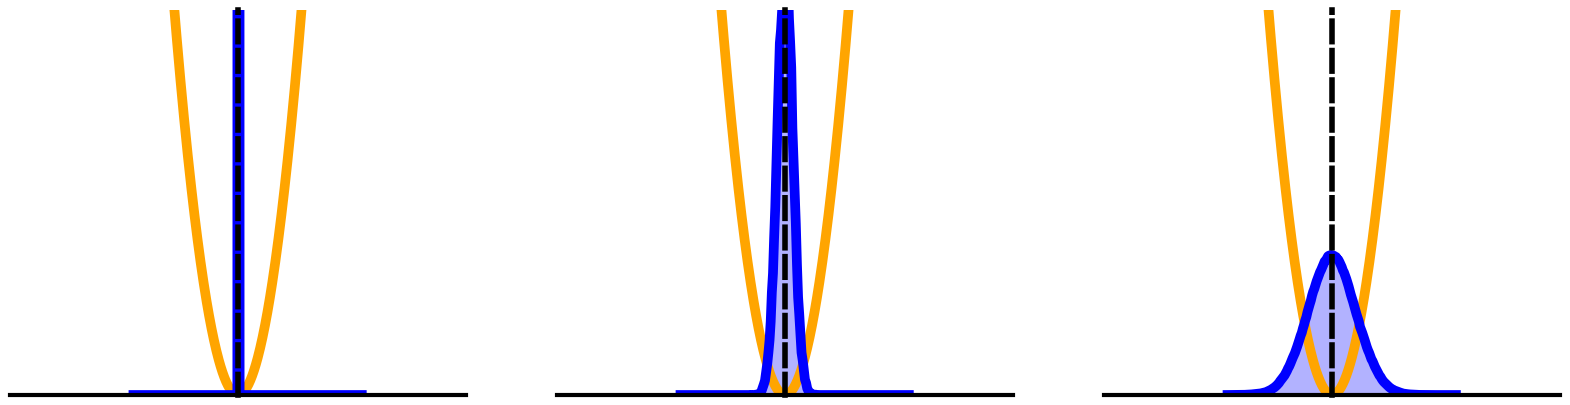

In [25]:
### plot no resetting histograms ###

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
axs = ax.ravel()
color = 'Blue'
boltzmann_histograms = histograms_per_rate[0]
xlim = (-3, 3)
ylim = (0, 3.5)
for i in range(3):
    if i == 0:
        hist, bin_centers = boltzmann_histograms[0]
    elif i == 1:
        hist, bin_centers = boltzmann_histograms[5]
    else:
        hist, bin_centers = boltzmann_histograms[-1]
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set(position=('data', 0), lw=4,linestyle='--')
    axs[i].spines['bottom'].set(lw=3)
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].plot(bin_centers, hist,color=color, linewidth=7, zorder=2)
    axs[i].fill_between(bin_centers, hist, alpha=0.3, color=color)
    axs[i].plot(potential_x, potential_y, label='U(x)', color='Orange', linewidth=7, zorder=1)
    axs[i].set_xlim(xlim[0], xlim[1])
    axs[i].set_ylim(*ylim)
#plt.tight_layout()
figname = 'a - Boltzmann PDF Relaxation - Harmonic.png'
path = os.path.join('..', 'FasterByResetting-Figures/Figure1',figname)
#plt.savefig(path, bbox_inches='tight',format='png', dpi=500)
plt.show()

resetting used:  0.12


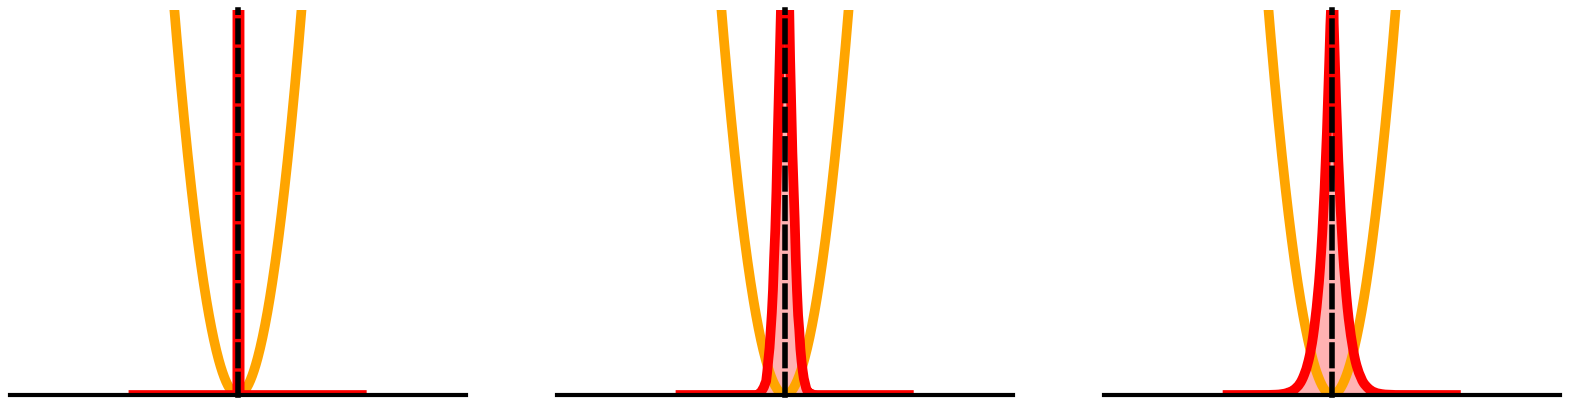

In [26]:
### plot no resetting histograms ###

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
axs = ax.ravel()

resetting_histograms = histograms_per_rate[3]
print('resetting used: ', resetting_rates[3])
color='r'
for i in range(3):
    if i == 0:
        hist, bin_centers = resetting_histograms[0]
        xlim = (-3, 3)
        ylim = (0, 3.5)
    elif i == 1:
        hist, bin_centers = resetting_histograms[5]
        xlim = (-3, 3)
        ylim = (0, 3.5)
    else:
        hist, bin_centers = resetting_histograms[-1]
        xlim = (-3, 3)
        ylim = (0, 3.5)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set(position=('data', 0), lw=4,linestyle='--')
    axs[i].spines['bottom'].set(lw=3)
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].plot(bin_centers, hist,color=color, linewidth=7, zorder=2)
    axs[i].fill_between(bin_centers, hist, alpha=0.3, color=color)
    axs[i].plot(potential_x, potential_y, label='U(x)', color='Orange', linewidth=7, zorder=1)
    axs[i].set_xlim(xlim[0], xlim[1])
    axs[i].set_ylim(*ylim)
#plt.tight_layout()
figname = 'a - Resetting PDF Relaxation - Harmonic.png'
path = os.path.join('..', 'FasterByResetting-Figures/Figure1',figname)
#plt.savefig(path, bbox_inches='tight',format='png', dpi=500, pad_inches=0)
plt.show()

In [27]:
def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

In [28]:
import mpl_toolkits.axes_grid1 as axes_grid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Make a user-defined colormap.
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b",'purple',"r"])

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].
cnorm = mcol.Normalize(vmin=min(resetting_rates),vmax=max(resetting_rates))

# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)

#####  NO Batches Analysis Of KLD relaxation 


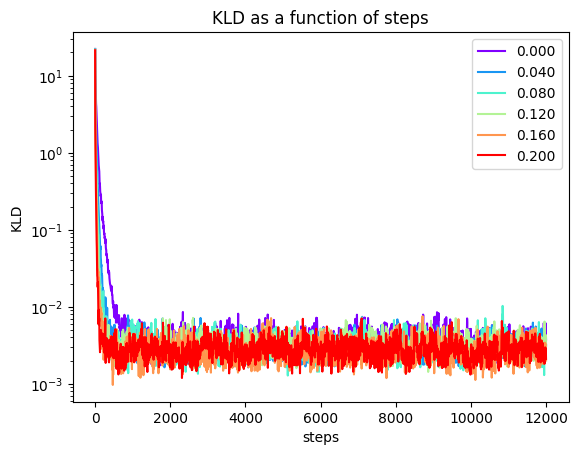

KLD threshold: 0.010952335369011905


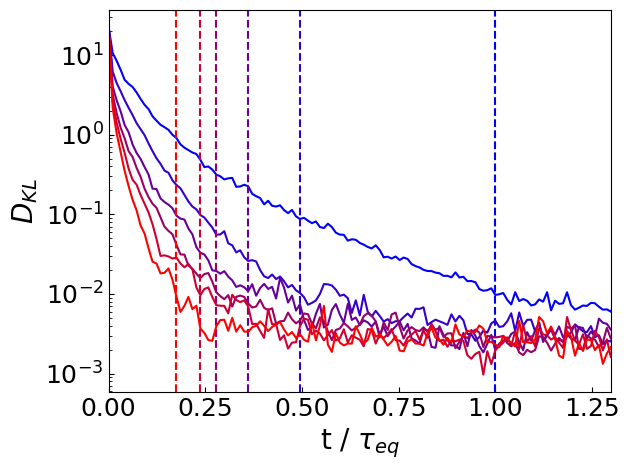

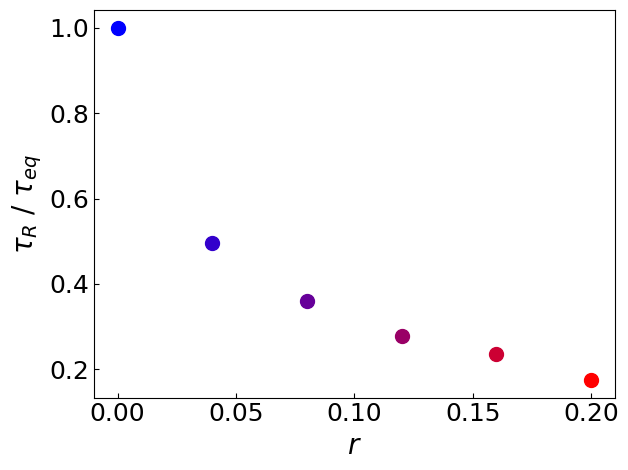

In [29]:
###  NO Batches Analysis Of KLD relaxation ###
#raise KeyboardInterrupt

KLDs_per_rate = []
for histograms_per_time, resetting_rate in zip(histograms_per_rate, resetting_rates):
    KLDs_by_time_per_rate = []
    shift = 0
    x_intercept = 0
    delta_fraction = resetting_rate*dt
    harmonic_pdf_args = [k_harm, delta_fraction, shift, dt, kT, gamma, x_intercept]
    eps = 1e-10
    pdf_values = histograms_per_time[-1][0] + eps

    for hist, bin_centers in histograms_per_time[:-1]:
        hist = hist + eps
        kld = stats.entropy(pdf_values, hist)
        KLDs_by_time_per_rate.append(kld)
        
    KLDs_by_time_per_rate = np.array(KLDs_by_time_per_rate)
    nans, x = nan_helper(KLDs_by_time_per_rate)
    if np.sum(nans) != 0:
        KLDs_by_time_per_rate[nans] = np.interp(x(nans), x(~nans), np.array(KLDs_by_time_per_rate)[~nans])
    KLDs_per_rate.append(KLDs_by_time_per_rate)
KLDs_per_rate = np.array(KLDs_per_rate)

### plot KLDs ###

timesteps = np.arange(0, steady_state, 5)
for kld_per_time, r, c in zip(KLDs_per_rate, resetting_rates, colors):
    plt.semilogy(timesteps,kld_per_time, label=f'{r:.3f}', color=c)
plt.xlabel('steps')
plt.ylabel('KLD')
plt.title('KLD as a function of steps')
plt.legend()
plt.show()


fig, ax = plt.subplots()

platue_index_per_r = []
kld_thresholds = []
for kld_per_time in KLDs_per_rate:
    kld_threshold = np.min(kld_per_time[-50:])
    kld_threshold_std = np.std(kld_per_time[-50:])
    kld_threshold = kld_threshold + 10*kld_threshold_std
    kld_thresholds.append(kld_threshold)
kld_threshold = max(kld_thresholds)
print('KLD threshold:', kld_threshold)

for kld_per_time, r, c in zip(KLDs_per_rate, resetting_rates, colors):
    platue_index = np.where(kld_per_time < kld_threshold)[0][0]
    timestep_platue = timesteps[platue_index]*dt/typical_relaxation_time
    platue_index_per_r.append(timestep_platue)
platue_index_per_r = np.array(platue_index_per_r)
for kld_per_time, platue, r, c in zip(KLDs_per_rate, platue_index_per_r, resetting_rates, colors):
    adjusted_timesteps = timesteps*dt/typical_relaxation_time
    adjusted_timesteps = adjusted_timesteps/platue_index_per_r[0]
    adjusted_platue = platue/platue_index_per_r[0]
    im=ax.semilogy(adjusted_timesteps,kld_per_time, label=f'{r:.3f}', color=cpick.to_rgba(r))
    im=ax.axvline(adjusted_platue, color=cpick.to_rgba(r), linestyle='--')
kld_line_handle = plt.Line2D([0],[0],linestyle='-',color='Black', label='KLD')
platue_index_handle = plt.Line2D([0],[0],linestyle='--',color='Black', label=f'$\\tau_R$')
resetting_rate_handles = []
for r, c in zip(resetting_rates, colors):
    h = plt.bar([0],[0],color=cpick.to_rgba(r),label=f'r={r:.3f}')
    resetting_rate_handles.append(h)
handles = [kld_line_handle, platue_index_handle] + resetting_rate_handles
ax.set_xlabel('t / $\\tau_{eq}$', fontsize=20)
ax.set_ylabel('$D_{KL}$',fontsize=20)
ax.tick_params(axis='both', which='both', labelsize=18, direction='in')
ax.set_xlim(0, 1.3)
ax.set_yscale('log')
plt.tight_layout()
plt.show()

colors_resetting = [cpick.to_rgba(r) for r in resetting_rates]
for i, r in enumerate(resetting_rates):
    plt.errorbar(resetting_rates[i], platue_index_per_r[i]/platue_index_per_r[0], linestyle='--', marker = 'o', lw=3, ms=10, color=colors_resetting[i])
#plt.plot(resetting_rates, mean_platue_indices_per_r, linestyle='--', lw=3, color='black', alpha=0.3)
plt.xlabel('$r$', fontsize=20)
plt.ylabel('$\\tau_R$ / $\\tau_{eq}$', fontsize=20)
plt.tick_params(axis='both', which='both', labelsize=18, direction='in')
plt.tight_layout()
plt.show()

##### Batched Analysis of the KLD relaxation

In [30]:
total_batches = 0
for filename in os.listdir(folder):
    if filename.endswith('.npy') and filename[0:5] == 'batch':
        total_batches += 1
print('Total Batches: ', total_batches)

Total Batches:  2


In [31]:
try:
    if trajectories_per_rate is None:
        filenames = os.listdir(folder)
        trajectories = np.load(folder+'/'+filenames[0])
        trajectories_per_rate = np.array(trajectories)
        del trajectories
except NameError:
    filenames = os.listdir(folder)
    trajectories = np.load(folder+'/'+filenames[0])
    trajectories_per_rate = np.array(trajectories)
    del trajectories

In [32]:
samples = 5
target_distribution_samples = 500
steady_state = 12000
timesteps = np.arange(0, steady_state, 5)
histograms_per_start_pos = []
bin_edges = np.histogram_bin_edges(trajectories_per_rate[-1][-samples:], bins=201)
bins = bin_edges*2

In [33]:
del trajectories_per_rate

In [34]:
### Characterize Steady State Index of the KLDs using batches to estimate error bars ###
samples = 5
target_distribution_samples = 500
steady_state = 12000
timesteps = np.arange(0, steady_state, samples)
histograms_per_BRT = [] #Batch Start Time

for i in tqdm(range(total_batches)):
    histograms_per_RT = []
    for filename in os.listdir(folder):
        check_if_batch_file =  re.search("^batch"and"\.npy$", filename) != None
        batch_found = ''.join(re.findall(r'\d', filename))
        if check_if_batch_file and batch_found == str(i+1):
            trajectories = np.load(folder+'/'+filename)
            trajectories_per_r = np.array(trajectories)
            del trajectories
            break
    histograms_per_RT = generate_histograms_per_rate(trajectories_per_r, bins, timesteps, samples, target_distribution_samples)
    del trajectories_per_r
    histograms_per_BRT.append(histograms_per_RT)
    print(f'Finished batch {i+1} of {total_batches}')
histograms_per_BRT = np.array(histograms_per_BRT)

<>:11: SyntaxWarning: invalid escape sequence '\.'
<>:11: SyntaxWarning: invalid escape sequence '\.'
C:\Users\nir19\AppData\Local\Temp\ipykernel_8960\2889950324.py:11: SyntaxWarning: invalid escape sequence '\.'
  check_if_batch_file =  re.search("^batch"and"\.npy$", filename) != None


  0%|          | 0/2 [00:00<?, ?it/s]

Finished batch 1 of 2
Finished batch 2 of 2


In [35]:
np.save(folder+'/histograms_per_BRT.npy', histograms_per_BRT)

In [36]:
histograms_per_BRT = np.load(folder+'/histograms_per_BRT.npy')

In [37]:
### Calculate KLDs per rate ###
#raise KeyboardInterrupt
KLDs_per_BR = []
for i, histograms_per_RT in tqdm(enumerate(histograms_per_BRT)):
    KLDs_per_R = []
    for histograms_per_time, resetting_rate in zip(histograms_per_RT, resetting_rates):
        KLDs_by_TR = []
        shift = 0
        x_intercept = 0
        delta_fraction = resetting_rate*dt
        harmonic_pdf_args = [k_harm, delta_fraction, shift, dt, kT, gamma, x_intercept]
        eps = 1e-10
        '''
        if resetting_rate == 0:
            pdf_values = histograms_per_time[-1][0] + eps
        else:
            pdf = lambda x: pdf_resetting_in_harmonic_potential(x, *harmonic_pdf_args)
            pdf_values = pdf(bin_centers) + eps
        '''
        pdf_values = histograms_per_time[-1][0] + eps

        for hist, bin_centers in histograms_per_time[:-1]:
            hist = hist + eps
            kld = stats.entropy(pdf_values, hist)
            KLDs_by_TR.append(kld)
        


        KLDs_by_TR = np.array(KLDs_by_TR)
        nans, x = nan_helper(KLDs_by_TR)
        if np.sum(nans) != 0:
            KLDs_by_TR[nans] = np.interp(x(nans), x(~nans), np.array(KLDs_by_TR)[~nans])
        KLDs_per_R.append(KLDs_by_TR)
    KLDs_per_R = np.array(KLDs_per_R)
    KLDs_per_BR.append(KLDs_per_R)
KLDs_per_BR = np.array(KLDs_per_BR)
KLDs_per_rate_per_batch = KLDs_per_BR

0it [00:00, ?it/s]

In [38]:
np.save(folder+f'/KLDs_per_BR.npy', KLDs_per_BR)

In [39]:
samples = 5
target_distribution_samples = 500
steady_state = 12000
KLDs_per_rate_per_batch = np.load(folder+f'/KLDs_per_BR.npy')
timesteps = np.arange(0, steady_state, 5)

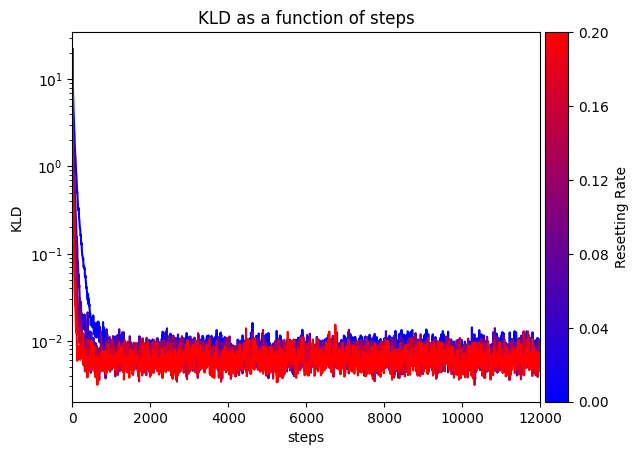

In [40]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
KLDs_per_rate = np.mean(KLDs_per_rate_per_batch, axis=0)
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

for kld_per_time, r, c in zip(KLDs_per_rate, resetting_rates, colors):
    im = ax.semilogy(timesteps,kld_per_time, label=f'{r:.3f}', color=cpick.to_rgba(r))
fig.colorbar(cpick, cax=cax, label='Resetting Rate', ticks=resetting_rates)
ax.set_xlabel('steps')
ax.set_ylabel('KLD')
ax.set_title('KLD as a function of steps')
ax.set_xlim(0, 12000)
plt.show()

In [41]:
np.save(folder+'/KLD_per_rate.npy', KLDs_per_rate)

KLD threshold: 0.038840349621793786
KLD threshold: 0.03166808297852202


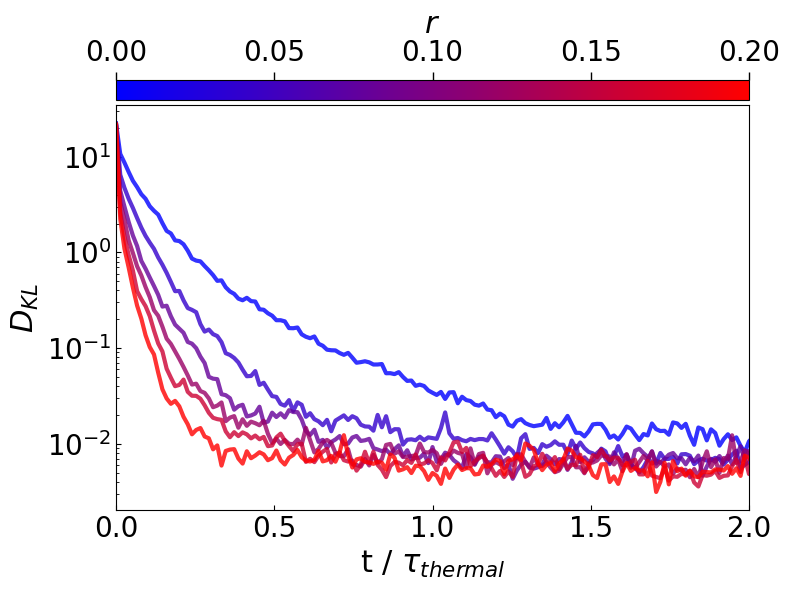

In [42]:
fig, ax = plt.subplots(figsize=(8, 6))
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='5%', pad=0.05)

platue_indices_per_r = []
for klds_per_batch in KLDs_per_rate_per_batch:
    platue_index_per_r = []
    kld_thresholds = []
    for kld_per_time in klds_per_batch:
        kld_threshold = np.mean(kld_per_time[-100:])
        kld_threshold_std = np.std(kld_per_time[-100:])
        kld_threshold = kld_threshold + 10*kld_threshold_std
        kld_thresholds.append(kld_threshold)
    kld_threshold = np.max(kld_thresholds)
    print('KLD threshold:', kld_threshold)
    for kld_per_time, r, c in zip(klds_per_batch, resetting_rates, colors):
        '''
        kld_threshold = np.mean(kld_per_time[-50:])
        kld_threshold_std = np.std(kld_per_time[-50:])
        kld_threshold = kld_threshold + 3*kld_threshold_std
        '''
        platue_index = np.where(kld_per_time < kld_threshold)[0][0]
        timestep_platue = timesteps[platue_index]*dt
        adjusted_platue = timestep_platue/typical_relaxation_time
        platue_index_per_r.append(adjusted_platue)
    platue_indices_per_r.append(platue_index_per_r)
platue_indices_per_r = np.array(platue_indices_per_r)
mean_platue_indices_per_r = np.mean(platue_indices_per_r, axis=0)
std_platue_indices_per_r = np.std(platue_indices_per_r, axis=0)
for kld_per_time, platue, r, c in zip(KLDs_per_rate, mean_platue_indices_per_r, resetting_rates, colors):
    adjusted_timesteps = timesteps*dt/typical_relaxation_time
    adjusted_timesteps = adjusted_timesteps/mean_platue_indices_per_r[0]
    adjusted_platue = platue/mean_platue_indices_per_r[0]
    im=ax.plot(adjusted_timesteps,kld_per_time, label=f'{r:.3f}', color=cpick.to_rgba(r), lw=3, alpha=0.8)
    #im=ax.axvline(adjusted_platue, color=cpick.to_rgba(r), linestyle='--')
cbar = fig.colorbar(cpick, cax=cax, orientation='horizontal',ticklocation='top')
cbar.ax.tick_params(labelsize=20, direction='out', length=6, width=1)
cbar.ax.set_xlabel('$r$', fontsize=22)
kld_line_handle = plt.Line2D([0],[0],linestyle='-',color='Black', label='KLD')
platue_index_handle = plt.Line2D([0],[0],linestyle='--',color='Black', label=f'$\\tau_R$')
resetting_rate_handles = []
for r, c in zip(resetting_rates, colors):
    h = plt.bar([0],[0],color=cpick.to_rgba(r),label=f'r={r:.3f}')
    resetting_rate_handles.append(h)
handles = [kld_line_handle, platue_index_handle] + resetting_rate_handles
ax.set_xlabel('t / $\\tau_{thermal}$', fontsize=22)
ax.set_ylabel('$D_{KL}$',fontsize=22)
ax.tick_params(axis='both', which='both', labelsize=20, direction='in')
ax.set_xlim(0, 2)
ax.set_yscale('log')
plt.tight_layout()
figname = 'b - KLD by steps - Harmonic.png'
path = os.path.join('..', 'FasterByResetting-Figures/Figure1',figname)
#plt.savefig(path,bbox_inches='tight',format='png', dpi=500)
plt.show()

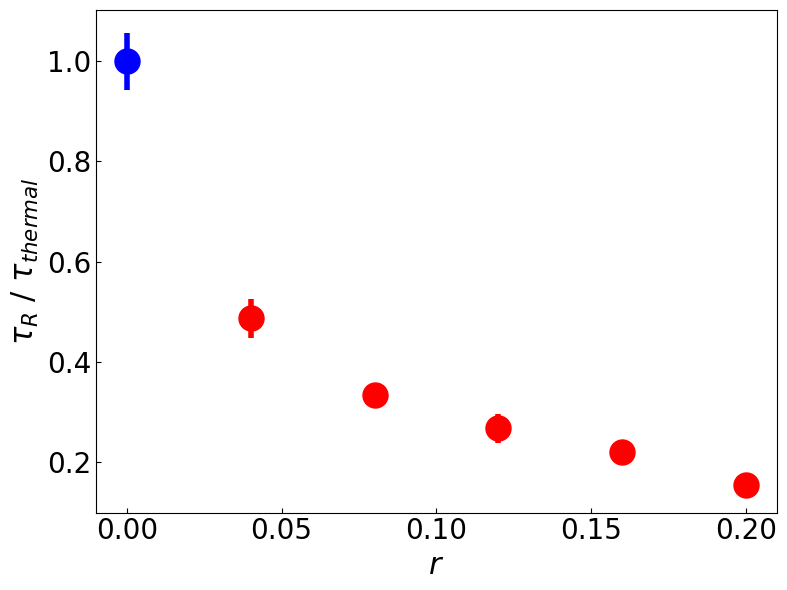

In [43]:
fig, ax = plt.subplots(figsize=(8, 6))
colors_resetting = [cpick.to_rgba(r) for r in resetting_rates]
for i, r in enumerate(resetting_rates):
    if i == 0:
        color = 'Blue'
    else:
        color = 'red'
    yerr = np.sqrt((std_platue_indices_per_r[i]/mean_platue_indices_per_r[0])**2 + ((mean_platue_indices_per_r[i]*std_platue_indices_per_r[0])/(mean_platue_indices_per_r[0]**2))**2)
    ax.errorbar(resetting_rates[i], mean_platue_indices_per_r[i]/mean_platue_indices_per_r[0], yerr=yerr, linestyle='--', marker = 'o', lw=4, ms=18, color=color)
ax.set_xlabel('$r$', fontsize=22)
ax.set_ylabel('$\\tau_R$ / $\\tau_{thermal}$', fontsize=22)
ax.tick_params(axis='both', which='both', labelsize=20, direction='in')
fig.tight_layout()
figname = 'c - Relaxation by resetting rate - Harmonic.png'
path = os.path.join('..', 'FasterByResetting-Figures/Figure1',figname)
#plt.savefig(path, bbox_inches='tight',format='png', dpi=500)
plt.show()

In [44]:
np.save(folder+f'/mean_platue_indices_per_r.npy', mean_platue_indices_per_r)
np.save(folder+f'/std_platue_indices_per_r.npy', std_platue_indices_per_r)
np.save(folder+f'/resetting_rates.npy', np.array(resetting_rates))